In [1]:
from torch import nn
import torch

In [2]:
from torch.nn.utils.rnn import pad_sequence

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import os

In [6]:
from einops import rearrange

In [7]:
import random

In [8]:
from torch.utils.data import DataLoader

In [9]:
import torchvision.transforms as T

In [10]:
from skimage.util import random_noise

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [12]:
import torchaudio

C:\Users\aag12\anaconda3\envs\ml_env\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [13]:
from sklearn import preprocessing

In [14]:
from sklearn.model_selection import train_test_split

# Defining Dataseat

In [15]:
from datasets import load_dataset

In [16]:
from datasets import disable_caching
disable_caching()

In [17]:
with open("goodfiles.txt", 'r') as f:
    all_files = f.readlines()
all_files = [g.strip().replace("npy", 'mp3') for g in all_files if len(g.strip()) > 0]

In [18]:
all_files[:3]

['01/846501.mp3', '34/1288334.mp3', '98/1082098.mp3']

In [19]:
good_files, test_files = train_test_split(all_files, test_size=0.2)

In [20]:
len(good_files), len(test_files)

(2200, 551)

In [21]:
def files_to_labels(files):
    col_names = ['TRACK_ID',
     'ARTIST_ID',
     'ALBUM_ID',
     'PATH',
     'DURATION',
     'TAGS',
     'TAGS2',
     'TAGS3',
     'TAGS4',
     'TAGS5',
     'TAGS6',
     'TAGS7',
     'TAGS8',
     'TAGS9']
    MOODPATH = "../../../Downloads/autotagging_moodtheme.tsv.txt"
    df = pd.read_csv(MOODPATH, sep='\t', names=col_names)
    df = df[df["PATH"].isin(files)]
    inds = {'fast': 0,
     'sexy': 1,
     'mellow': 2,
     'heavy': 3,
     'horror': 4,
     'travel': 5,
     'holiday': 6,
     'groovy': 7,
     'funny': 8,
     'retro': 9,
     'hopeful': 10,
     'powerful': 11,
     'cool': 12,
     'nature': 13,
     'game': 14}

    final_labels = []
    for i in range(len(df)):
        curr = np.zeros(len(inds))
        moods = list(df.iloc[i])[5:]
        for theme in moods:
            if type(theme) == str and "mood" in theme:
                check = theme.split("---")[-1]
                if check in inds:
                    curr[inds[check]] = 1
            else:
                pass

        final_labels.append(curr)
    return final_labels

In [22]:
train_labels = files_to_labels(good_files)

In [23]:
test_labels = files_to_labels(test_files)

In [24]:
train_labels[:2]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])]

In [25]:
# train_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in good_files]
# test_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in test_files]
train_np_files = ["../../mtg-jamendo-dataset/all_data/" + g.replace("mp3", "npy") for g in good_files]
test_np_files = ["../../mtg-jamendo-dataset/all_data/" + g.replace("mp3", "npy") for g in test_files]

In [26]:
train_np_files[:2], test_np_files[:2]

(['../../mtg-jamendo-dataset/all_data/93/1393193.npy',
  '../../mtg-jamendo-dataset/all_data/37/600037.npy'],
 ['../../mtg-jamendo-dataset/all_data/62/1190862.npy',
  '../../mtg-jamendo-dataset/all_data/38/1149238.npy'])

In [27]:
import time

In [28]:
# SEQ_LEN = 10000
SEQ_LEN = 3000
# SEQ_LEN = 5000

# Dataset

In [29]:
from torchvision import transforms

In [30]:
class MusicDataset(torch.utils.data.Dataset):   
    def __init__(self, np_file_paths, labels, transforms, seq_len=10000, random_start=True, upsample_factor=10):
        self.seq_len = seq_len
        self.files = np_file_paths
        self.labels = labels
        self.transforms = transforms
        self.random_start = random_start
        self.upsample_factor = upsample_factor
        
    def __len__(self):
        return len(self.files) * self.upsample_factor

    def __getitem__(self, index):
        effective_index = index % len(self.files)
        fname = self.files[effective_index]
        x = np.load(fname)
        x = torch.from_numpy(x).float()
        if self.random_start and x.shape[-1] > self.seq_len:
            # longer than seqlen, select random subset
            start = random.randint(0, x.shape[-1] - self.seq_len)
            x = x[:,start:start+self.seq_len]
        else:
            x = x[:,:self.seq_len]
        old_x = x.unsqueeze(0)
        # clamp between bounds and scale
        compressed_x = (torch.clamp(old_x, min=-90, max=30) + 90) / 120
        
        x = self.transforms(compressed_x)
        
#         item = {"input": x, "label_ids":[effective_index], "labels": torch.tensor(self.labels[effective_index])}
        item = {"input": x, "pixel_values":x}
        
        return item

In [31]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [32]:
img_size = 224
noise_composed = transforms.Compose([
   transforms.Resize((img_size, img_size)),
    transforms.Normalize((0.5542), (0.1604)),
    AddGaussianNoise(0., 0.04)
])
nonoise_composed = transforms.Compose([
   transforms.Resize((img_size, img_size)),
    transforms.Normalize((0.5542), (0.1604))
])

In [33]:
pt_train_dataset = MusicDataset(train_np_files, train_labels, noise_composed, seq_len=SEQ_LEN, random_start=True, upsample_factor=5)
pt_test_dataset = MusicDataset(test_np_files, test_labels, nonoise_composed, seq_len=SEQ_LEN, random_start=False, upsample_factor=1)

In [34]:
batch_size = 8

In [35]:
train_dl = DataLoader(
    pt_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

test_dl = DataLoader(
    pt_test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

# Small hface testing

In [36]:
from transformers import ViTMAEConfig, ViTMAEModel, ViTMAEForPreTraining, ViTFeatureExtractor

In [37]:
from transformers import ViTForImageClassification

In [38]:
configuration = ViTMAEConfig(
                    image_size=224, 
                    num_channels=1, 
#                     norm_pix_loss=True, 
                    num_attention_heads=6, 
                    num_hidden_layers=3,
                    decoder_intermediate_size=1024,
                    intermediate_size=2048
)

In [39]:
configuration

ViTMAEConfig {
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 512,
  "decoder_intermediate_size": 1024,
  "decoder_num_attention_heads": 16,
  "decoder_num_hidden_layers": 8,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "mask_ratio": 0.75,
  "model_type": "vit_mae",
  "norm_pix_loss": false,
  "num_attention_heads": 6,
  "num_channels": 1,
  "num_hidden_layers": 3,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.23.1"
}

In [40]:
# model = ViTMAEModel(configuration)
model = ViTMAEForPreTraining(configuration)

In [41]:
model

ViTMAEForPreTraining(
  (vit): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0): ViTMAELayer(
          (attention): ViTMAEAttention(
            (attention): ViTMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=768, out_features=2048, bias=True)

In [42]:
pt_train_dataset[0]['input'].shape

torch.Size([1, 224, 224])

In [43]:
ii = pt_train_dataset[0]['input']
iii = torch.stack([ii, ii, ii])

In [44]:
iii.shape

torch.Size([3, 1, 224, 224])

In [46]:
# model(iii)

In [47]:
from transformers import Trainer, TrainingArguments
from transformers.trainer_utils import get_last_checkpoint

In [48]:
training_args = TrainingArguments(
    "hface_test_v0",
#     learning_rate=1.5e-4,
    learning_rate=5e-3,
    weight_decay=0.05,
    num_train_epochs=100,
    per_device_train_batch_size=8,
    per_gpu_eval_batch_size=1,
    logging_steps=10,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=3,
    label_names=["pixel_values"],
)

In [49]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    return {"pixel_values": pixel_values}

In [50]:
trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=pt_train_dataset,
        eval_dataset=pt_test_dataset,
        tokenizer=ViTFeatureExtractor(do_resize=False, do_normalize=False),
        data_collator=collate_fn,
    )

In [51]:
trainer.train()

C:\Users\aag12\anaconda3\envs\ml_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 11000
  Num Epochs = 100
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 137500
The following columns in the training set don't have a corresponding argument in `ViTMAEForPreTraining.forward` and have been ignored: input. If input are not expected by `ViTMAEForPreTraining.forward`,  you can safely ignore this message.


Epoch,Training Loss,Validation Loss
1,0.327600,0.419200
2,0.487600,0.547053
3,0.473300,0.659032
4,0.395400,0.556165
5,0.398500,0.580979
6,0.415900,0.619614
7,0.451400,0.578727
8,0.368200,0.524327
9,0.358500,0.469495
10,0.374500,0.482712


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
***** Running Evaluation *****
  Num examples = 551
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTMAEForPreTraining.forward` and have been ignored: input. If input are not expected by `ViTMAEForPreTraining.forward`,  you can safely ignore this message.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Saving model checkpoint to hface_test_v0\checkpoint-1375
Configuration saved in hface_test_v0\checkpoint-1375\config.json
Model weights saved in hface_test_v0\checkpoint-1375\pytorch_model.bin
Feature extractor saved in hface_test_v0\checkpoint-

Saving model checkpoint to hface_test_v0\checkpoint-11000
Configuration saved in hface_test_v0\checkpoint-11000\config.json
Model weights saved in hface_test_v0\checkpoint-11000\pytorch_model.bin
Feature extractor saved in hface_test_v0\checkpoint-11000\preprocessor_config.json
Deleting older checkpoint [hface_test_v0\checkpoint-8250] due to args.save_total_limit
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
***** Running Evaluation *****
  Num examples = 551
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTMAEForPreTraining.forward` and have been ignored: input. If input are not expected by `ViTMAEForPreTraining.forward`,  you can safely ignore this message.
Using deprecated `--per_gpu

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
***** Running Evaluation *****
  Num examples = 551
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTMAEForPreTraining.forward` and have been ignored: input. If input are not expected by `ViTMAEForPreTraining.forward`,  you can safely ignore this message.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Saving model checkpoint to hface_test_v0\checkpoint-22000
Configuration saved in hface_test_v0\checkpoint-22000\config.json
Model weights saved in hface_test_v0\checkpoint-22000\pytorch_model.bin
Feature extractor saved in hface_test_v0\checkpoi

  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTMAEForPreTraining.forward` and have been ignored: input. If input are not expected by `ViTMAEForPreTraining.forward`,  you can safely ignore this message.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Saving model checkpoint to hface_test_v0\checkpoint-31625
Configuration saved in hface_test_v0\checkpoint-31625\config.json
Model weights saved in hface_test_v0\checkpoint-31625\pytorch_model.bin
Feature extractor saved in hface_test_v0\checkpoint-31625\preprocessor_config.json
Deleting older checkpoint [hface_test_v0\checkpoint-28875] due to args.save_total_limit
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in

Saving model checkpoint to hface_test_v0\checkpoint-41250
Configuration saved in hface_test_v0\checkpoint-41250\config.json
Model weights saved in hface_test_v0\checkpoint-41250\pytorch_model.bin
Feature extractor saved in hface_test_v0\checkpoint-41250\preprocessor_config.json
Deleting older checkpoint [hface_test_v0\checkpoint-38500] due to args.save_total_limit
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
***** Running Evaluation *****
  Num examples = 551
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTMAEForPreTraining.forward` and have been ignored: input. If input are not expected by `ViTMAEForPreTraining.forward`,  you can safely ignore this message.
Using deprecated `--per_gp

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
***** Running Evaluation *****
  Num examples = 551
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTMAEForPreTraining.forward` and have been ignored: input. If input are not expected by `ViTMAEForPreTraining.forward`,  you can safely ignore this message.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Saving model checkpoint to hface_test_v0\checkpoint-52250
Configuration saved in hface_test_v0\checkpoint-52250\config.json
Model weights saved in hface_test_v0\checkpoint-52250\pytorch_model.bin
Feature extractor saved in hface_test_v0\checkpoi

  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTMAEForPreTraining.forward` and have been ignored: input. If input are not expected by `ViTMAEForPreTraining.forward`,  you can safely ignore this message.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Saving model checkpoint to hface_test_v0\checkpoint-61875
Configuration saved in hface_test_v0\checkpoint-61875\config.json
Model weights saved in hface_test_v0\checkpoint-61875\pytorch_model.bin
Feature extractor saved in hface_test_v0\checkpoint-61875\preprocessor_config.json
Deleting older checkpoint [hface_test_v0\checkpoint-59125] due to args.save_total_limit
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in

Saving model checkpoint to hface_test_v0\checkpoint-71500
Configuration saved in hface_test_v0\checkpoint-71500\config.json
Model weights saved in hface_test_v0\checkpoint-71500\pytorch_model.bin
Feature extractor saved in hface_test_v0\checkpoint-71500\preprocessor_config.json
Deleting older checkpoint [hface_test_v0\checkpoint-68750] due to args.save_total_limit
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
***** Running Evaluation *****
  Num examples = 551
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTMAEForPreTraining.forward` and have been ignored: input. If input are not expected by `ViTMAEForPreTraining.forward`,  you can safely ignore this message.
Using deprecated `--per_gp

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
***** Running Evaluation *****
  Num examples = 551
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTMAEForPreTraining.forward` and have been ignored: input. If input are not expected by `ViTMAEForPreTraining.forward`,  you can safely ignore this message.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Saving model checkpoint to hface_test_v0\checkpoint-82500
Configuration saved in hface_test_v0\checkpoint-82500\config.json
Model weights saved in hface_test_v0\checkpoint-82500\pytorch_model.bin
Feature extractor saved in hface_test_v0\checkpoi

  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTMAEForPreTraining.forward` and have been ignored: input. If input are not expected by `ViTMAEForPreTraining.forward`,  you can safely ignore this message.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Saving model checkpoint to hface_test_v0\checkpoint-92125
Configuration saved in hface_test_v0\checkpoint-92125\config.json
Model weights saved in hface_test_v0\checkpoint-92125\pytorch_model.bin
Feature extractor saved in hface_test_v0\checkpoint-92125\preprocessor_config.json
Deleting older checkpoint [hface_test_v0\checkpoint-89375] due to args.save_total_limit
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in

Saving model checkpoint to hface_test_v0\checkpoint-101750
Configuration saved in hface_test_v0\checkpoint-101750\config.json
Model weights saved in hface_test_v0\checkpoint-101750\pytorch_model.bin
Feature extractor saved in hface_test_v0\checkpoint-101750\preprocessor_config.json
Deleting older checkpoint [hface_test_v0\checkpoint-99000] due to args.save_total_limit
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
***** Running Evaluation *****
  Num examples = 551
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTMAEForPreTraining.forward` and have been ignored: input. If input are not expected by `ViTMAEForPreTraining.forward`,  you can safely ignore this message.
Using deprecated `--pe

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
***** Running Evaluation *****
  Num examples = 551
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTMAEForPreTraining.forward` and have been ignored: input. If input are not expected by `ViTMAEForPreTraining.forward`,  you can safely ignore this message.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Saving model checkpoint to hface_test_v0\checkpoint-112750
Configuration saved in hface_test_v0\checkpoint-112750\config.json
Model weights saved in hface_test_v0\checkpoint-112750\pytorch_model.bin
Feature extractor saved in hface_test_v0\check

  Num examples = 551
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTMAEForPreTraining.forward` and have been ignored: input. If input are not expected by `ViTMAEForPreTraining.forward`,  you can safely ignore this message.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Saving model checkpoint to hface_test_v0\checkpoint-122375
Configuration saved in hface_test_v0\checkpoint-122375\config.json
Model weights saved in hface_test_v0\checkpoint-122375\pytorch_model.bin
Feature extractor saved in hface_test_v0\checkpoint-122375\preprocessor_config.json
Deleting older checkpoint [hface_test_v0\checkpoint-118250] due to args.save_total_limit
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argumen

Saving model checkpoint to hface_test_v0\checkpoint-132000
Configuration saved in hface_test_v0\checkpoint-132000\config.json
Model weights saved in hface_test_v0\checkpoint-132000\pytorch_model.bin
Feature extractor saved in hface_test_v0\checkpoint-132000\preprocessor_config.json
Deleting older checkpoint [hface_test_v0\checkpoint-127875] due to args.save_total_limit
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
***** Running Evaluation *****
  Num examples = 551
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTMAEForPreTraining.forward` and have been ignored: input. If input are not expected by `ViTMAEForPreTraining.forward`,  you can safely ignore this message.
Using deprecated `--p

TrainOutput(global_step=137500, training_loss=0.33032580840024084, metrics={'train_runtime': 17236.2479, 'train_samples_per_second': 63.819, 'train_steps_per_second': 7.977, 'total_flos': 1.13729689092096e+19, 'train_loss': 0.33032580840024084, 'epoch': 100.0})

In [52]:
trainer.save_model("hface_test_v0/final.pt")

Saving model checkpoint to hface_test_v0/final.pt
Configuration saved in hface_test_v0/final.pt\config.json
Model weights saved in hface_test_v0/final.pt\pytorch_model.bin
Feature extractor saved in hface_test_v0/final.pt\preprocessor_config.json


In [53]:
model.save_pretrained("hface_test_v0/final_mae.pt")

Configuration saved in hface_test_v0/final_mae.pt\config.json
Model weights saved in hface_test_v0/final_mae.pt\pytorch_model.bin


In [157]:
# -mask_ratio 0.75 \
#     --norm_pix_loss \
#     --do_train \
#     --do_eval \
#     --base_learning_rate 1.5e-4 \
#     --lr_scheduler_type cosine \
#     --weight_decay 0.05 \
#     --num_train_epochs 800 \
#     --warmup_ratio 0.05 \
#     --per_device_train_batch_size 8 \
#     --per_device_eval_batch_size 8 \
#     --logging_strategy steps \
#     --logging_steps 10 \
#     --evaluation_strategy epoch \
#     --save_strategy epoch \
#     --load_best_model_at_end True \
#     --save_total_limit 3 \
#     --seed 1337

## MAE

In [249]:
v = ViT(
    image_size = 500,
#     patch_size = 32,
    patch_size = 16,
    num_classes = 15,
#     dim = 1024,
    dim = 512,
    depth = 6,
    heads = 8,
#     mlp_dim = 2048,
    mlp_dim = 512,
    channels=1
)
mae = MAE(
    encoder = v,
    masking_ratio = 0.75,   # the paper recommended 75% masked patches
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
)

In [251]:
from tqdm import tqdm
import torch.optim as optim

In [252]:
mae = mae.to(DEVICE)

In [253]:
data.shape

torch.Size([8, 1, 224, 224])

In [254]:
def get_total_loss(model, dataloader):
    total_loss = 0
    for batch_idx, data in enumerate(dataloader):
        loss = mae(data.to(device))
        total_loss += loss.item()
    return total_loss

In [255]:
# optimizer = optim.AdamW(mae.parameters(), lr=1e-2)
# optimizer = optim.AdamW(mae.parameters(), lr=5e-2, weight_decay=0.05, betas=(0.9, 0.95))
optimizer = optim.AdamW(mae.parameters(), lr=5e-3, weight_decay=0.05, betas=(0.9, 0.95))

In [256]:
train_losses = []
test_losses = []
for epoch in range(100):
    total_loss = 0
    for batch_idx, data in tqdm(enumerate(train_dl), total=len(train_dl)):
        optimizer.zero_grad()
        
        loss = mae(data.to(device))
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    with torch.no_grad():
        test_loss = get_total_loss(model, test_dl)
        train_losses.append(total_loss)
        test_losses.append(test_loss)
        print(f"Epoch: {epoch}; Loss: {total_loss}; Test Loss: {test_loss}")
    if test_loss == min(test_losses):
        torch.save(v.state_dict(), f"./trained-vit-{epoch}.pt")

_ = mae.eval()

100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:25<00:00, 10.84it/s]


Epoch: 0; Loss: 276080.3042449951; Test Loss: 246350.5579147339


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:25<00:00, 10.83it/s]


Epoch: 1; Loss: 89291.69067382812; Test Loss: 140533.61388397217


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.78it/s]


Epoch: 2; Loss: 54749.39376068115; Test Loss: 96360.1615486145


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.81it/s]


Epoch: 3; Loss: 48744.62087249756; Test Loss: 83770.93311691284


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.63it/s]


Epoch: 4; Loss: 43921.656311035156; Test Loss: 78264.68698692322


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.33it/s]


Epoch: 5; Loss: 40744.013359069824; Test Loss: 81621.57325744629


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.77it/s]


Epoch: 6; Loss: 38521.14498138428; Test Loss: 76112.8122215271


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.79it/s]


Epoch: 7; Loss: 39314.981216430664; Test Loss: 78907.4281539917


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.20it/s]


Epoch: 8; Loss: 37101.98306274414; Test Loss: 72873.41133499146


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.54it/s]


Epoch: 9; Loss: 37447.97604370117; Test Loss: 74116.89520454407


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.77it/s]


Epoch: 10; Loss: 38564.417976379395; Test Loss: 71480.00602912903


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.77it/s]


Epoch: 11; Loss: 37344.94650268555; Test Loss: 69573.21865081787


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:25<00:00, 10.96it/s]


Epoch: 12; Loss: 35259.97687149048; Test Loss: 68291.31255722046


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.77it/s]


Epoch: 13; Loss: 34774.32368469238; Test Loss: 70128.72945213318


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.77it/s]


Epoch: 14; Loss: 34367.07344055176; Test Loss: 64517.289363861084


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.79it/s]


Epoch: 15; Loss: 34087.94969558716; Test Loss: 64260.59979057312


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.01it/s]


Epoch: 16; Loss: 39253.41689300537; Test Loss: 63982.686040878296


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.79it/s]


Epoch: 17; Loss: 33696.09609222412; Test Loss: 64116.94851875305


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.80it/s]


Epoch: 18; Loss: 33439.7018737793; Test Loss: 62960.07576942444


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.45it/s]


Epoch: 19; Loss: 33231.4119720459; Test Loss: 63414.529989242554


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.41it/s]


Epoch: 20; Loss: 33528.21862792969; Test Loss: 64198.66967201233


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.77it/s]


Epoch: 21; Loss: 33123.91159057617; Test Loss: 62405.891607284546


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.74it/s]


Epoch: 22; Loss: 32624.351928710938; Test Loss: 62492.674715042114


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.11it/s]


Epoch: 23; Loss: 32692.774353027344; Test Loss: 62482.71595954895


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.78it/s]


Epoch: 24; Loss: 32527.833568572998; Test Loss: 64123.42633628845


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.83it/s]


Epoch: 25; Loss: 32729.608673095703; Test Loss: 64575.148067474365


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.79it/s]


Epoch: 26; Loss: 32585.535484313965; Test Loss: 64037.85218048096


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:25<00:00, 10.92it/s]


Epoch: 27; Loss: 32540.621856689453; Test Loss: 58861.048990249634


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.78it/s]


Epoch: 28; Loss: 32262.860801696777; Test Loss: 62310.73246002197


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.76it/s]


Epoch: 29; Loss: 32077.321975708008; Test Loss: 61365.99906539917


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.62it/s]


Epoch: 30; Loss: 32290.115825653076; Test Loss: 62180.878032684326


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:32<00:00,  8.54it/s]


Epoch: 31; Loss: 31770.214351654053; Test Loss: 63384.885791778564


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:25<00:00, 10.89it/s]


Epoch: 32; Loss: 32172.485313415527; Test Loss: 67790.1958732605


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.76it/s]


Epoch: 33; Loss: 32014.1664352417; Test Loss: 62485.85102844238


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:25<00:00, 10.95it/s]


Epoch: 34; Loss: 31977.01109313965; Test Loss: 62845.21714782715


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.73it/s]


Epoch: 35; Loss: 32266.510864257812; Test Loss: 62610.413579940796


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.75it/s]


Epoch: 36; Loss: 31842.93252182007; Test Loss: 60536.518907547


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.64it/s]


Epoch: 37; Loss: 32036.33642578125; Test Loss: 69159.2629070282


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.28it/s]


Epoch: 38; Loss: 31939.500198364258; Test Loss: 61691.8097076416


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.77it/s]


Epoch: 39; Loss: 31813.528816223145; Test Loss: 63400.95610618591


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.82it/s]


Epoch: 40; Loss: 31659.230533599854; Test Loss: 64084.54666137695


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.52it/s]


Epoch: 41; Loss: 31789.322193145752; Test Loss: 63040.64032936096


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.45it/s]


Epoch: 42; Loss: 31776.0304107666; Test Loss: 62634.44348335266


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.80it/s]


Epoch: 43; Loss: 31546.23041152954; Test Loss: 60606.60872268677


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.82it/s]


Epoch: 44; Loss: 31711.528747558594; Test Loss: 61192.1139755249


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.15it/s]


Epoch: 45; Loss: 31438.24723815918; Test Loss: 62366.50410270691


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.80it/s]


Epoch: 46; Loss: 31485.332569122314; Test Loss: 59283.84027290344


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.79it/s]


Epoch: 47; Loss: 31516.596271514893; Test Loss: 60040.50053024292


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.81it/s]


Epoch: 48; Loss: 31627.313526153564; Test Loss: 59621.68665885925


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.20it/s]


Epoch: 49; Loss: 31377.757362365723; Test Loss: 59619.49256324768


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.80it/s]


Epoch: 50; Loss: 31536.31558227539; Test Loss: 59540.72929382324


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.80it/s]


Epoch: 51; Loss: 31206.057327270508; Test Loss: 61438.022062301636


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.70it/s]


Epoch: 52; Loss: 31353.19784927368; Test Loss: 58263.9245929718


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.28it/s]


Epoch: 53; Loss: 31330.62195968628; Test Loss: 58904.20904922485


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.82it/s]


Epoch: 54; Loss: 31120.392684936523; Test Loss: 60504.27367019653


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.79it/s]


Epoch: 55; Loss: 31487.384742736816; Test Loss: 71139.6710472107


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.53it/s]


Epoch: 56; Loss: 31281.676010131836; Test Loss: 62416.58356285095


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.54it/s]


Epoch: 57; Loss: 31330.523864746094; Test Loss: 65686.55772399902


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.80it/s]


Epoch: 58; Loss: 31054.891708374023; Test Loss: 62164.995641708374


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.83it/s]


Epoch: 59; Loss: 31307.556316375732; Test Loss: 64342.106439590454


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.03it/s]


Epoch: 60; Loss: 31212.03783416748; Test Loss: 60124.2713470459


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.71it/s]


Epoch: 61; Loss: 31233.347076416016; Test Loss: 59062.84935760498


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.78it/s]


Epoch: 62; Loss: 31084.09398651123; Test Loss: 60232.30786895752


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.78it/s]


Epoch: 63; Loss: 31249.912872314453; Test Loss: 60855.75570678711


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:25<00:00, 11.00it/s]


Epoch: 64; Loss: 31176.66524887085; Test Loss: 59502.97692871094


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.71it/s]


Epoch: 65; Loss: 31194.1668510437; Test Loss: 61483.98736000061


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.75it/s]


Epoch: 66; Loss: 31039.03722000122; Test Loss: 59375.24447631836


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.46it/s]


Epoch: 67; Loss: 30878.195476531982; Test Loss: 58671.19668006897


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.33it/s]


Epoch: 68; Loss: 31101.62539291382; Test Loss: 59497.98830413818


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.76it/s]


Epoch: 69; Loss: 31255.86809539795; Test Loss: 57928.4369392395


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.74it/s]


Epoch: 70; Loss: 30859.056114196777; Test Loss: 58360.06322669983


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.25it/s]


Epoch: 71; Loss: 30945.903812408447; Test Loss: 59921.462911605835


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.69it/s]


Epoch: 72; Loss: 31021.851440429688; Test Loss: 60211.430028915405


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.73it/s]


Epoch: 73; Loss: 30954.92714691162; Test Loss: 60183.2161655426


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.80it/s]


Epoch: 74; Loss: 31194.60179901123; Test Loss: 60798.046617507935


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:25<00:00, 10.83it/s]


Epoch: 75; Loss: 31070.525840759277; Test Loss: 59354.38853645325


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.73it/s]


Epoch: 76; Loss: 31174.45948791504; Test Loss: 69144.55572891235


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.70it/s]


Epoch: 77; Loss: 30934.80707168579; Test Loss: 59280.320837020874


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.72it/s]


Epoch: 78; Loss: 30928.584762573242; Test Loss: 61938.89379310608


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.07it/s]


Epoch: 79; Loss: 30884.75291824341; Test Loss: 59649.7091255188


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.82it/s]


Epoch: 80; Loss: 31047.251041412354; Test Loss: 63060.00495529175


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.75it/s]


Epoch: 81; Loss: 30755.207469940186; Test Loss: 59032.56268310547


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.49it/s]


Epoch: 82; Loss: 30642.4167137146; Test Loss: 59811.915309906006


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.53it/s]


Epoch: 83; Loss: 31015.34331893921; Test Loss: 59629.43381690979


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.74it/s]


Epoch: 84; Loss: 30912.756088256836; Test Loss: 61631.67461967468


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.71it/s]


Epoch: 85; Loss: 30863.185497283936; Test Loss: 61497.50419807434


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.02it/s]


Epoch: 86; Loss: 31043.876613616943; Test Loss: 60640.17737197876


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.75it/s]


Epoch: 87; Loss: 30665.318630218506; Test Loss: 59728.285568237305


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.75it/s]


Epoch: 88; Loss: 31147.4487991333; Test Loss: 58179.90757369995


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.76it/s]


Epoch: 89; Loss: 30914.44522857666; Test Loss: 60071.09903717041


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:25<00:00, 10.92it/s]


Epoch: 90; Loss: 30964.728981018066; Test Loss: 58520.20722961426


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.73it/s]


Epoch: 91; Loss: 30785.10216140747; Test Loss: 58938.9517288208


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.76it/s]


Epoch: 92; Loss: 31053.523887634277; Test Loss: 60718.51557159424


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.54it/s]


Epoch: 93; Loss: 30698.90421295166; Test Loss: 66016.17458724976


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.22it/s]


Epoch: 94; Loss: 30831.16035079956; Test Loss: 58507.77581214905


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.76it/s]


Epoch: 95; Loss: 30737.15912628174; Test Loss: 65662.72535133362


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.78it/s]


Epoch: 96; Loss: 31069.696098327637; Test Loss: 58491.41403198242


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:24<00:00, 11.22it/s]


Epoch: 97; Loss: 30868.474266052246; Test Loss: 63202.20079994202


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.54it/s]


Epoch: 98; Loss: 30767.019939422607; Test Loss: 59759.9649105072


100%|████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:23<00:00, 11.74it/s]


Epoch: 99; Loss: 31040.607460021973; Test Loss: 58119.37052536011


In [269]:
# torch.save(v.state_dict(), f"./lastnotbest-trained-vit-{epoch}.pt")
torch.save(mae.state_dict(), f"./maeklastnotbest-trained-vit-{epoch}.pt")

In [257]:
30 * 800 / 60 / 60

6.666666666666667

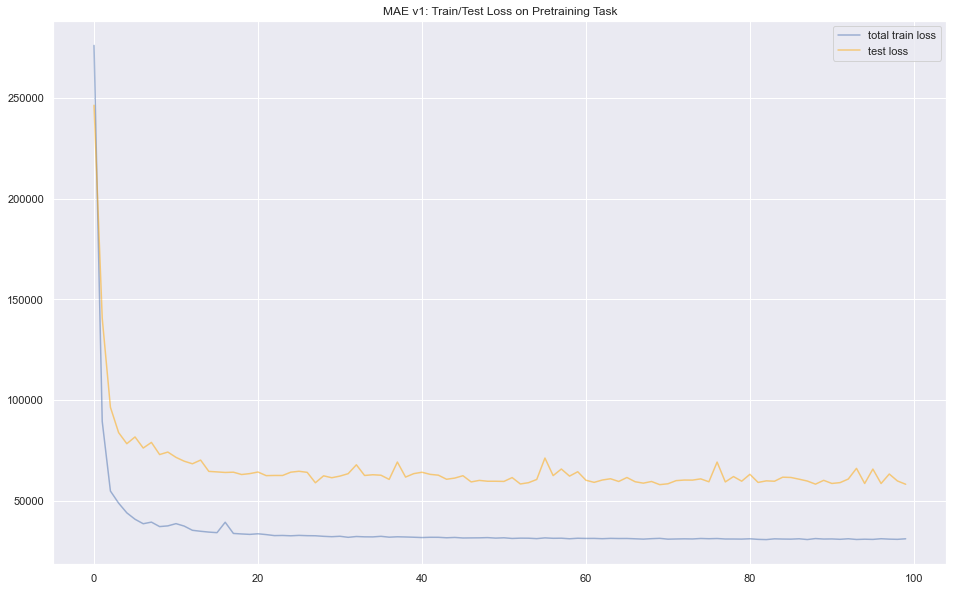

In [272]:
plt.figure(figsize=(16, 10))
ranger = list(range(len(train_losses)))
sns.lineplot(x=ranger, y=train_losses, label="total train loss", alpha=0.5)
# sns.lineplot(x=ranger, y=adjusted_train_losses, label="adjusted train loss")
# ax2 = plt.twinx()
# sns.lineplot(x=ranger, y=test_losses, label="test loss", ax=ax2, color="orange", alpha=0.5)
sns.lineplot(x=ranger, y=test_losses, label="test loss", color="orange", alpha=0.5)
plt.title("MAE v1: Train/Test Loss on Pretraining Task")
plt.savefig("mae_v1.png")

# Finetuning MAE for Task

In [64]:
batch_size = 8

In [265]:
class FinetuningMusicDataset(torch.utils.data.Dataset):   
    def __init__(self, np_file_paths, labels, transforms, seq_len=10000, random_start=True, upsample_factor=10):
        self.seq_len = seq_len
        self.files = np_file_paths
        self.labels = labels
        self.transforms = transforms
        self.random_start = random_start
        self.upsample_factor = upsample_factor
    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        x = np.load(self.files[index])
        x = torch.from_numpy(x).float()
        if self.random_start and x.shape[-1] > self.seq_len:
            # longer than 3000, select random subset
            start = random.randint(0, x.shape[-1] - self.seq_len)
            x = x[:,start:start+self.seq_len]
        else:
            x = x[:,:self.seq_len]
        old_x = x.unsqueeze(0)
        xs = []
        for i in range(self.upsample_factor):
            x = self.transforms(old_x)
            xs.append(x)
        x = torch.cat(xs)
        item = {"input": x, "label_ids":[index for i in range(self.upsample_factor)], "labels": torch.tensor(self.labels[index])}
        
        return item

In [266]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [267]:
noise_composed = transforms.Compose([
   transforms.Resize((224, 224)),
    AddGaussianNoise(0., 1.)
])
nonoise_composed = transforms.Compose([
   transforms.Resize((224, 224)),
])

In [268]:
composed(inp).shape

torch.Size([1, 224, 224])

In [269]:
res.shape

torch.Size([1, 224, 224])

In [272]:
ft_train_dataset = FinetuningMusicDataset(train_np_files, train_labels, noise_composed, seq_len=SEQ_LEN, random_start=True)
ft_test_dataset = FinetuningMusicDataset(test_np_files, test_labels, nonoise_composed, seq_len=SEQ_LEN, random_start=False)

In [271]:
ft_train_dl = DataLoader(
    ft_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

ft_test_dl = DataLoader(
    ft_test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

In [72]:
from transformers import ViTConfig, ViTModel
from vit_pytorch import ViT, MAE

In [73]:
v_for_downstream = ViT(
    image_size = 224,
#     patch_size = 32,
    patch_size = 16,
    num_classes = 15,
#     dim = 1024,
    dim = 512,
    depth = 6,
    heads = 8,
#     mlp_dim = 2048,
    mlp_dim = 512,
    channels=1
)

In [74]:
v_for_downstream.load_state_dict(torch.load(f"./trained-vit-69.pt"))

<All keys matched successfully>

In [75]:
v_for_downstream.mlp_head

Sequential(
  (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=512, out_features=15, bias=True)
)

In [78]:
def set_module_requires_grad_(module, requires_grad):
    for param in module.parameters():
        param.requires_grad = requires_grad
def freeze_all_layers_(module):
    set_module_requires_grad_(module, False)

In [79]:
freeze_all_layers_(v_for_downstream)

In [91]:
new_head = nn.Sequential(
    nn.LayerNorm(512),
    nn.Linear(512, 512),
    nn.Linear(512, 15),
#     nn.Sigmoid()
)

In [93]:
# for param in v_for_downstream.transformer.parameters():
#     print(param.requires_grad)

In [94]:
# model = nn.Sequential(
#     v_for_downstream,
#     nn.Sigmoid()
# )

In [95]:
v_for_downstream.to(device)(go)

tensor([[-0.2859,  0.2516,  0.2906, -0.2965,  0.1036, -0.4781, -0.2801,  0.2640,
         -0.1523,  0.1146, -0.2998, -0.4838,  0.0065, -0.2667, -0.0189]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [96]:
model = v_for_downstream.to(device)

In [97]:
from tqdm import tqdm
import torch.optim as optim

In [99]:
torch.sum(torch.tensor(train_labels), dim=0) / len(train_labels)

tensor([0.0418, 0.0432, 0.0605, 0.0595, 0.0577, 0.0573, 0.0641, 0.0727, 0.0709,
        0.0759, 0.0777, 0.0850, 0.0877, 0.0991, 0.0936], dtype=torch.float64)

In [100]:
len(train_labels)

2200

In [110]:
torch.sum(torch.tensor(train_labels), dim=0) / len(train_labels)

tensor([0.0418, 0.0432, 0.0605, 0.0595, 0.0577, 0.0573, 0.0641, 0.0727, 0.0709,
        0.0759, 0.0777, 0.0850, 0.0877, 0.0991, 0.0936], dtype=torch.float64)

In [111]:
# pos_weight = torch.ones([15]) * (14/1)
# pos_weight = torch.ones([15]) * (13/1)
pos_weight = 1 / (torch.sum(torch.tensor(train_labels), dim=0) / len(train_labels))

In [112]:
pos_weight

tensor([23.9130, 23.1579, 16.5414, 16.7939, 17.3228, 17.4603, 15.6028, 13.7500,
        14.1026, 13.1737, 12.8655, 11.7647, 11.3990, 10.0917, 10.6796],
       dtype=torch.float64)

In [113]:
model.parameters()

<generator object Module.parameters at 0x000001C4D40DB120>

In [114]:
# optimizer = optim.AdamW(model.parameters(), lr=1e-3)
# optimizer = optim.AdamW(model.parameters(), lr=1e-4)
# optimizer = optim.AdamW(model.mlp_head.parameters(), lr=1e-3)
# optimizer = optim.AdamW(model.mlp_head.parameters(), lr=1e-2)
optimizer = optim.AdamW(model.mlp_head.parameters(), lr=1e-2, weight_decay=0.05, betas=(0.9, 0.95))
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight.to(device))

In [115]:
def get_mask(targs):
    mask = []
    for val in targs:
        m = int(val) == 1 or random.random() < (1/15)
        mask.append(m)
    return mask

In [116]:
def get_total_loss(model, dataloader):
    total_loss = 0
    for batch_idx, data in enumerate(dataloader):
        inputs, labels = data['input'].to(device), data['labels'].to(device)

        outputs = model(inputs)
        total_loss += criterion(outputs, labels.float())
#         for i in range(15):
#             cur_loss = criterion(outputs[:,i], labels[:,i].float())
#             total_loss += cur_loss
    return total_loss.item()

In [163]:
train_dataset[0]

{'input': tensor([[[  3.9402,   7.9499,   7.8935,  ..., -21.0093, -21.9212, -54.1739],
          [  8.6965,  10.3651,   9.0643,  ..., -22.3698, -21.4546, -51.6610],
          [  5.7967,   6.3847,   5.8797,  ..., -15.6461, -25.2399, -45.4402],
          ...,
          [ -2.4321,  -0.3850,  -4.3144,  ..., -27.1652, -30.1625, -52.6164],
          [ -7.9795,  -7.5831,  -8.7472,  ..., -22.3573, -28.2247, -49.4764],
          [  0.8661,   1.4261,   5.6780,  ..., -22.2884, -27.2021, -47.2621]]]),
 'label_ids': [0],
 'labels': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        dtype=torch.float64)}

In [117]:
model.train()
ft_train_losses = []
ft_test_losses = []
for epoch in range(10):
# for epoch in range(5):
    total_loss = 0
#     for batch in train_loader:
    for batch_idx, data in tqdm(enumerate(ft_train_dl), total=len(ft_train_dl)):
        these_losses = []
        optimizer.zero_grad()
        inputs, labels = data['input'].to(device), data['labels'].to(device)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        # for bookkeeping
        total_loss += loss.item()
        
    with torch.no_grad():
        train_total_loss = total_loss
        test_loss = get_total_loss(model, ft_test_dl)
        ft_train_losses.append(train_total_loss)
        ft_test_losses.append(test_loss)
        print(f"Epoch: {epoch}; Loss: {adjusted}; Total Loss: {train_total_loss}; Test Loss: {test_loss}")
#         print(f"Epoch: {epoch}; Loss: {adjusted}; Test Loss: {test_loss}")

_ = model.eval()

  0%|                                                                                                  | 0/275 [00:00<?, ?it/s]


ZeroDivisionError: division by zero

Text(0.5, 1.0, 'MAE v1: Finetuning Train/Test Loss')

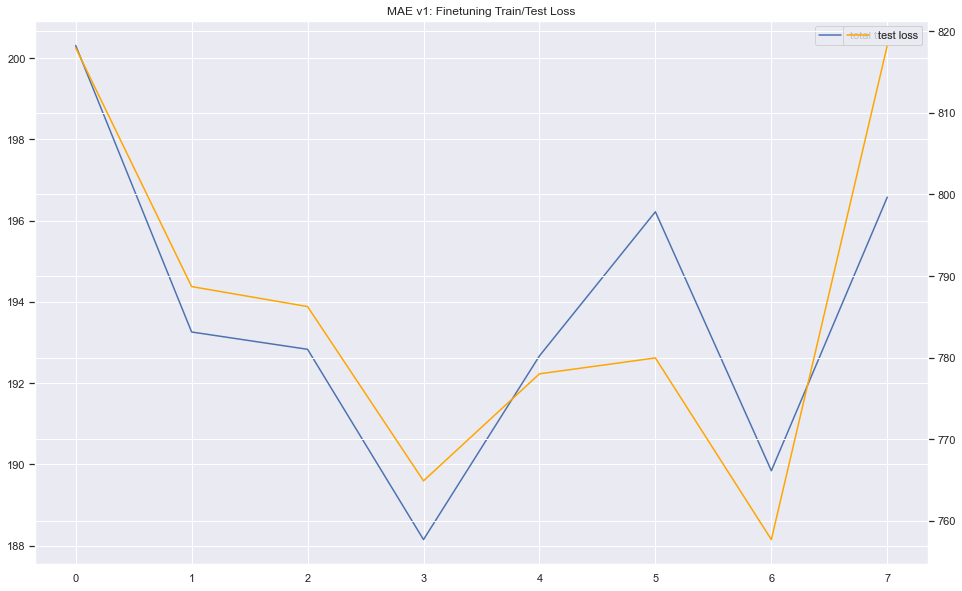

In [718]:
plt.figure(figsize=(16, 10))
ranger = list(range(len(ft_train_losses)))
sns.lineplot(x=ranger, y=ft_train_losses, label="total train loss", alpha=1)
# sns.lineplot(x=ranger, y=adjusted_train_losses, label="adjusted train loss")
ax2 = plt.twinx()
sns.lineplot(x=ranger, y=ft_test_losses, label="test loss", ax=ax2, color="orange", alpha=1)
# sns.lineplot(x=ranger, y=ft_test_losses, label="test loss", color="orange", alpha=0.5)
plt.title("MAE v1: Finetuning Train/Test Loss")
# plt.savefig("mae_v1.png")

In [719]:
import torch.nn.functional as F

In [720]:
model.eval()

combined_preds = []
combined_labels = []

with torch.no_grad():
#     a = model(dataset[2]['input'].to(device))
    total_correct = 0
    zero_correct = 0
    total_values = 0
    only_positives = [0, 0]
    for batch_idx, data in enumerate(ft_test_dl):
        inputs, labels = data['input'].to(device), data['labels'].to(device)

        outputs = model(inputs)
        
        outputs = F.sigmoid(outputs)
        
        combined_preds.append(outputs)
        combined_labels.append(labels)
        
        outlabels = torch.zeros_like(outputs)
        outlabels[outputs >= 0.5] = 1
        outlabels[outputs < 0.5] = 0
        
        num_correct = torch.sum(outlabels == labels).item()
        num = len(labels) * 15
        
        total_correct += num_correct
        total_values += num
        zero_correct += torch.sum(labels == 0).item()
        
        only_positives[0] += torch.sum(labels).item()
        only_positives[1] += torch.sum(labels[labels == 1] == outlabels[labels == 1]).item()
        

print(total_correct / total_values)

print(f"{total_correct} out of {total_values}")

print("Performance on positive labels")

print(only_positives[1] / only_positives[0])

print(f"{only_positives[1]} out of {only_positives[0]}")

print("WHAT IF WE JUST PREDICTED ZERO")

print(zero_correct / total_values)

print(f"{zero_correct} out of {total_values}")

C:\Users\aag12\anaconda3\envs\ml_env\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.47017543859649125
3886 out of 8265
Performance on positive labels
0.6313993174061433
370 out of 586.0
WHAT IF WE JUST PREDICTED ZERO
0.9290986085904416
7679 out of 8265


In [721]:
all_preds = torch.cat(combined_preds)
all_labels = torch.cat(combined_labels)
all_preds.shape, all_labels.shape

(torch.Size([551, 15]), torch.Size([551, 15]))

In [722]:
len(ft_test_dataset)

551

In [723]:
from sklearn import metrics

In [724]:
aucs = []
for i in range(15):
    preds = all_preds[:,i].cpu()
    targs = all_labels[:,i].cpu()
#     fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    aucs.append(auc)
    print(f"Head: {i}; AUC: {auc}")

Head: 0; AUC: 0.49550763701707096
Head: 1; AUC: 0.4770579137308816
Head: 2; AUC: 0.5974904942965779
Head: 3; AUC: 0.5150930150930151
Head: 4; AUC: 0.5039867109634552
Head: 5; AUC: 0.4518659881255301
Head: 6; AUC: 0.4548867903060644
Head: 7; AUC: 0.47853399105904115
Head: 8; AUC: 0.545631067961165
Head: 9; AUC: 0.5038710135663045
Head: 10; AUC: 0.47422046552481334
Head: 11; AUC: 0.5870875179340029
Head: 12; AUC: 0.48699932111337413
Head: 13; AUC: 0.5397166935628475
Head: 14; AUC: 0.5077129443326627


In [618]:
sum(aucs) / len(aucs)

0.49143731402460067

In [556]:
from sklearn.metrics import roc_auc_score

In [557]:
roc_auc_score(targs, preds)

0.5556300767568373

In [558]:
import scikitplot as skplt
import matplotlib.pyplot as plt

In [559]:
from vit_pytorch.learnable_memory_vit import ViT, Adapter

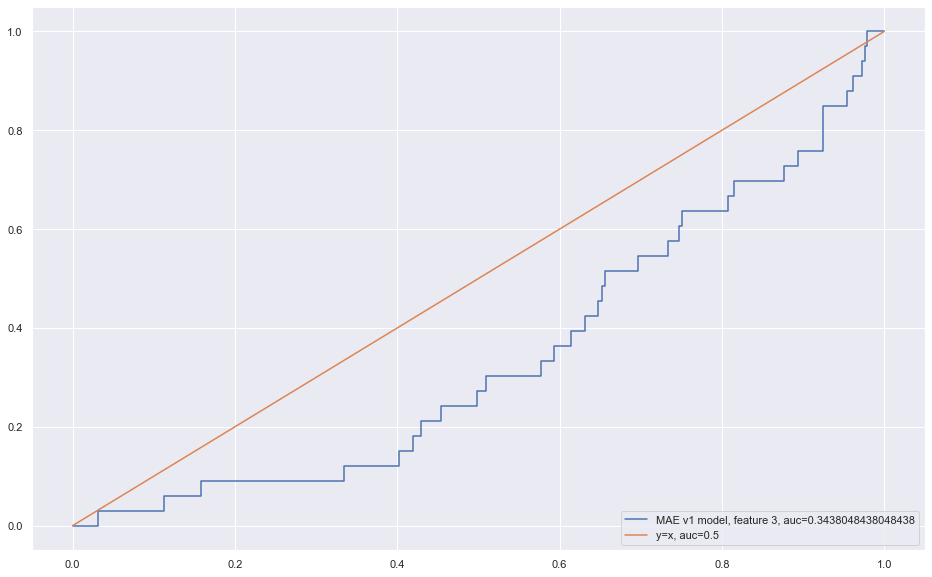

In [565]:
plt.figure(figsize=(16, 10))
preds = all_preds[:,3].cpu()
targs = all_labels[:,3].cpu()
fpr, tpr, _ = metrics.roc_curve(targs, preds)
auc = metrics.roc_auc_score(targs, preds)
plt.plot(fpr,tpr,label="MAE v1 model, feature 3, auc="+str(auc))

fpr, tpr, _ = metrics.roc_curve(targs, np.zeros_like(targs))
auc = metrics.roc_auc_score(targs, np.zeros_like(targs))
plt.plot(fpr,tpr,label="y=x, auc="+str(auc))

plt.legend(loc=4)
plt.show()